# Data Import and Analysis

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gpu_available = tf.config.list_physical_devices('GPU')
if gpu_available:
    print(f"Using GPU: {gpu_available}")
else:
    print("GPU not available, using CPU.")

Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
df = pd.read_csv('/kaggle/input/vner-vlsp-2021/processed_data.csv')

In [5]:
df

,Word,Tag,Sentence #
0,Mong ước,O,Sentence: 1
1,được,O,Sentence: 1
2,đến,O,Sentence: 1
3,trường,O,Sentence: 1
4,của,O,Sentence: 1
...,...,...,...
981550,dưới,O,Sentence: 26649
981551,16,B-QUANTITY-AGE,Sentence: 26649
981552,-,I-QUANTITY-AGE,Sentence: 26650
981553,QUANTITY-NUM,I-QUANTITY-AGE,Sentence: 26650


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


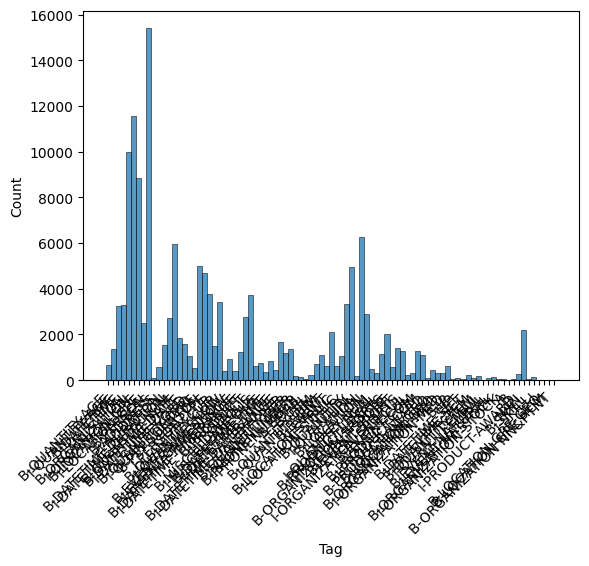

In [6]:
sns.histplot(df[df['Tag']!='O']['Tag'])
plt.xticks(rotation=45, ha='right')
plt.show()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981555 entries, 0 to 981554
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Word        981555 non-null  object
 1   Tag         981555 non-null  object
 2   Sentence #  981555 non-null  object
dtypes: object(3)
memory usage: 22.5+ MB


In [8]:
print('Number of sentences are '+str(df['Sentence #'].nunique()))
print('Number of words are '+str(df['Word'].nunique()))

Number of sentences are 26394
Number of words are 42919


# Model Building LSTM

## Data Preprocessing

In [9]:
import tensorflow as tf
import gensim.downloader as api
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
tf.random.set_seed(123)

In [10]:
df['Word']=df['Word'].str.lower()

In [11]:
sentence_all = [(list(zip(group['Word'], group['Tag']))) for _, group in df.groupby('Sentence #')]

In [12]:
sentence_all[0] #1st Sentence

[('mong ước', 'O'),
 ('được', 'O'),
 ('đến', 'O'),
 ('trường', 'O'),
 ('của', 'O'),
 ('bé', 'O'),
 ('gái', 'O'),
 ('7', 'B-QUANTITY-AGE'),
 ('tuổi', 'I-QUANTITY-AGE')]

In [13]:
if tf.test.is_gpu_available():
    BATCH_SIZE = 512 
    EPOCHS = 5  
    MAX_LEN = 75
    EMBEDDING = 40  
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

In [14]:
! pip install keras_preprocessing

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00


In [15]:
import numpy as np
from gensim.models import FastText
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical 

In [16]:
def create_fasttext_embeddings(sentences, embedding_dim=300):
    sentences_for_fasttext = [[w[0] for w in sent] for sent in sentences]
    
    # Train FastText model
    model = FastText(vector_size=embedding_dim,
                    window=5,
                    min_count=1,
                    workers=4)
    
    model.build_vocab(sentences_for_fasttext)
    model.train(sentences_for_fasttext,
                total_examples=len(sentences_for_fasttext),
                epochs=20)
    
    return model

In [ ]:
words = list(set(df['Word'].values))
tags = list(set(df["Tag"].values))

In [17]:
# Create word and tag indices
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0

idx2word = {i: w for w, i in word2idx.items()}

tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

idx2tag = {i: w for w, i in tag2idx.items()}

# Train FastText model
embedding_dim = 300
fasttext_model = create_fasttext_embeddings(sentence_all, embedding_dim)

embedding_matrix = np.zeros((len(word2idx), embedding_dim))
for word, i in word2idx.items():
    try:
        embedding_matrix[i] = fasttext_model.wv[word]
    except KeyError:
        embedding_matrix[i] = np.random.uniform(-0.25, 0.25, embedding_dim)

In [18]:
# Prepare sequences
MAX_LEN = 75
X = [[word2idx[w[0]] for w in s] for s in sentence_all]
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Prepare labels
y = [[tag2idx[w[1]] for w in s] for s in sentence_all]
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])
y = [to_categorical(i, num_classes=len(tags)+1) for i in y]

In [20]:
tags = list(set(df["Tag"].values))
num_tags = len(tags)

In [21]:
num_tags

90

## Model Building

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Bidirectional
from sklearn.model_selection import train_test_split

# Split data
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
y_tr, y_te = np.array(y_tr), np.array(y_te)

In [23]:
# Define the model
def build_model(max_len=75, input_dim=len(word2idx), embedding_dim=300, num_classes=91):
    input_layer = Input(shape=(max_len,))
    
    embedding_layer = Embedding(
        input_dim,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        mask_zero=True,
        trainable=True,
        name='embedding_layer'
    )(input_layer)
    
    lstm_1 = Bidirectional(LSTM(units=50, return_sequences=True))(embedding_layer)
    lstm_2 = Bidirectional(LSTM(units=100, return_sequences=True))(lstm_1)
    lstm_3 = Bidirectional(LSTM(units=50, return_sequences=True))(lstm_2)
    
    dense = TimeDistributed(Dense(25, activation="relu"))(lstm_3)
    
    # Update the number of output units to match the number of classes
    output = TimeDistributed(Dense(num_classes, activation='softmax'), name='output_layer')(dense)

    model = Model(input_layer, output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create and train the model
model = build_model()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='ner_model.weights.h5',
        monitor='val_loss',
        save_weights_only=True,
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        verbose=1,
        patience=5
    )
]

# Train the model
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_te, y_te),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
742/743 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8910 - loss: 1.0670
Epoch 1: val_loss improved from inf to 0.49513, saving model to ner_model.weights.h5
743/743 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.8910 - loss: 1.0661 - val_accuracy: 0.9032 - val_loss: 0.4951
Epoch 2/100
743/743 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9153 - loss: 0.4289
Epoch 2: val_loss improved from 0.49513 to 0.37693, saving model to ner_model.weights.h5
743/743 ━━━━━━━━━━━━━━━━━━━━ 31s 42ms/step - accuracy: 0.9153 - loss: 0.4288 - val_accuracy: 0.9134 - val_loss: 0.3769
Epoch 3/100
743/743 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9259 - loss: 0.3140
Epoch 3: val_loss improved from 0.37693 to 0.34229, saving model to ner_model.weights.h5
743/743 ━━━━━━━━━━━━━━━━━━━━ 31s 42ms/step - accuracy: 0.9259 - loss: 0.3140 - val_accuracy: 0.9163 - val_loss: 0.2423
Epoch 4/100
742/743 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9316 - loss: 0.2543
Epoch 4: val_loss improved f

## Evaluation

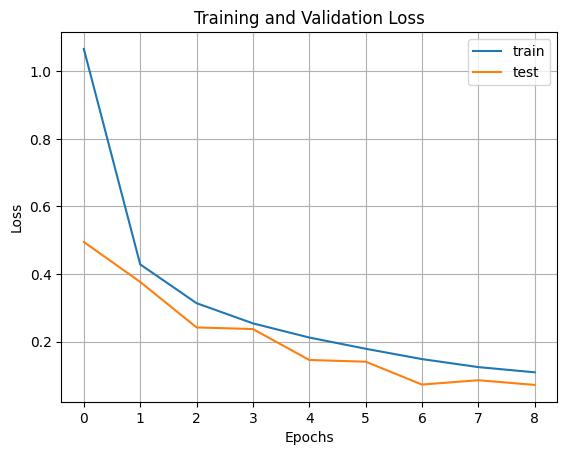

In [3]:
import matplotlib.pyplot as pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.title('Training and Validation Loss')
pyplot.legend()
pyplot.grid(True)
pyplot.show()

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model.predict(X_te)

# Convert predictions to POS tags
predicted_tags = np.argmax(predictions, axis=-1)
predicted_tags = [[idx2tag[tag] for tag in sample] for sample in predicted_tags]

# Flatten the predicted and true POS tag sequences
flatten_predicted = [tag for sample in predicted_tags for tag in sample]
flatten_true = [idx2tag[np.argmax(tag)] for sample in y_te for tag in sample]

# Get unique tags from the true and predicted sequences
unique_tags = list(set(flatten_true + flatten_predicted))

83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step


In [26]:
from sklearn.metrics import classification_report
print("Classification Report:\n ", classification_report(flatten_predicted, flatten_true, labels=unique_tags, zero_division=0))

Classification Report:
                         precision    recall  f1-score   support

        B-EVENT-SPORT       0.68      0.76      0.71        66
           I-LOCATION       0.55      0.50      0.52       258
          B-EVENT-CUL       0.37      0.70      0.48        10
       B-ORGANIZATION       0.75      0.72      0.73       941
       I-QUANTITY-NUM       0.15      0.62      0.24        13
       I-DATETIME-SET       0.29      0.80      0.42         5
       I-QUANTITY-ORD       0.49      0.54      0.51        41
        B-PHONENUMBER       0.44      0.73      0.55        11
       B-LOCATION-GEO       0.22      0.36      0.27        22
       I-QUANTITY-DIM       0.61      0.88      0.72        90
      B-DATETIME-DATE       0.60      0.58      0.59       174
      I-PRODUCT-AWARD       0.37      0.88      0.52         8
      B-MISCELLANEOUS       0.15      0.39      0.21        23
       B-QUANTITY-DIM       0.15      0.54      0.23        24
       I-QUANTITY-TEM       1

In [27]:
model.save('/kaggle/working/model_fasttext_lstm.h5')

## Conclusion

In [28]:
import numpy as np

def get_pos_tags(sentence):
    tokens = sentence.lower().split()

    word_indices = [word2idx.get(token, word2idx["UNK"]) for token in tokens]

    padded_sequence = pad_sequences([word_indices], maxlen=MAX_LEN, padding="post", value=word2idx["PAD"])

    # Make predictions
    predictions = model.predict(padded_sequence)[0]

    # Convert predictions to POS tags
    pos_tags = [idx2tag[np.argmax(pred)] for pred in predictions]

    return list(zip(tokens, pos_tags))

# Example usage
input_sentence = "Hôm nay tôi đi tới trường học dự lễ khai giảng"
output = get_pos_tags(input_sentence)

# Print the output
for token, pos_tag in output:
    print(f"Token: {token:<10} Predicted POS: {pos_tag}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Token: hôm        Predicted POS: B-DATETIME
Token: nay        Predicted POS: I-DATETIME
Token: tôi        Predicted POS: O
Token: đi         Predicted POS: O
Token: tới        Predicted POS: O
Token: trường     Predicted POS: O
Token: học        Predicted POS: O
Token: dự         Predicted POS: O
Token: lễ         Predicted POS: O
Token: khai       Predicted POS: O
Token: giảng      Predicted POS: O
